# Projeto Completo de Conversor Boost DC-DC

Este notebook apresenta o projeto completo de um conversor Boost (elevador de tensão), incluindo:

1. **Especificações e Topologia**
2. **Projeto do Indutor e Capacitor**
3. **Seleção de Componentes (MOSFET e Diodo)**
4. **Análise de Pequenos Sinais**
5. **Projeto do Controlador PI**
6. **Simulação em Malha Aberta**
7. **Simulação em Malha Fechada**
8. **Validação Final**

## Topologia do Boost Converter

```
    L          D
Vin──┬──LLLL──►|──┬──────┬── Vout
     │            │      │
     │    S      === C   R  Load
     │    │       │      │
     └────┴───────┴──────┴── GND
```

**Princípio de operação:**
- **S ON**: Energia armazenada no indutor (V_L = Vin)
- **S OFF**: Energia transferida para carga (V_L = Vin - Vout)
- **Relação**: Vout = Vin / (1 - D)

In [35]:
from pathlib import Path
import sys

_root = Path.cwd()
_candidate_paths = []
for _ in range(6):
    for _rel in (('build-test', 'python'), ('build', 'python')):
        candidate = _root / _rel[0] / _rel[1]
        if candidate.is_dir():
            _candidate_paths.append(candidate)
    _root = _root.parent

_unique_candidates = []
_seen = set()
for candidate in _candidate_paths:
    cstr = str(candidate)
    if cstr in _seen:
        continue
    _seen.add(cstr)
    _unique_candidates.append(candidate)

_bootstrap_error = None
for candidate in _unique_candidates:
    cstr = str(candidate)
    if cstr not in sys.path:
        sys.path.insert(0, cstr)
    try:
        import pulsim  # noqa: F401
        break
    except Exception as exc:
        _bootstrap_error = exc
        if cstr in sys.path:
            sys.path.remove(cstr)
else:
    if _bootstrap_error is not None:
        raise _bootstrap_error

# ============================================================
# SETUP E IMPORTS
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

import pulsim as ps

print(f"PulsimCore versão: {ps.__version__}")
print("="*70)
print("PROJETO DE CONVERSOR BOOST DC-DC")
print("="*70)

PulsimCore versão: 0.3.3
PROJETO DE CONVERSOR BOOST DC-DC


In [ ]:
# Compat helper for Pulsim >=0.4 (Simulator API)
try:
    _PS = ps  # notebooks que usam alias 'ps'
except NameError:
    import pulsim as _PS

def run_transient_compat(circuit, t_start, t_stop, dt, x0=None, newton_options=None, linear_solver=None):
    """Bridge helper: mantem o retorno (times, states, success, msg) com a API atual."""

    def _legacy_call():
        args = []
        if x0 is not None:
            args.append(x0)
        if newton_options is not None:
            args.append(newton_options)
        if linear_solver is not None:
            args.append(linear_solver)
        return _PS.run_transient(circuit, t_start, t_stop, dt, *args)

    if hasattr(_PS, "SimulationOptions") and hasattr(_PS, "Simulator"):
        try:
            opts = _PS.SimulationOptions()
            opts.tstart = float(t_start)
            opts.tstop = float(t_stop)
            opts.dt = float(dt)

            if hasattr(opts, "dt_min"):
                opts.dt_min = min(float(opts.dt_min), float(dt))
            if hasattr(opts, "dt_max"):
                opts.dt_max = max(float(opts.dt_max), float(dt))

            if newton_options is not None:
                opts.newton_options = newton_options
            if linear_solver is not None and hasattr(opts, "linear_solver"):
                opts.linear_solver = linear_solver

            sim = _PS.Simulator(circuit, opts)
            if x0 is None:
                result = sim.run_transient()
            else:
                result = sim.run_transient(x0)
            if result.success or not hasattr(_PS, "run_transient"):
                return result.time, result.states, bool(result.success), str(result.message)

            # Fallback robusto para preservar notebooks mais antigos.
            return _legacy_call()
        except Exception:
            if hasattr(_PS, "run_transient"):
                return _legacy_call()
            raise

    return _legacy_call()


## 1. Especificações do Projeto

Vamos projetar um Boost converter para uma aplicação típica de elevação de tensão de bateria.

In [36]:
# ============================================================
# ESPECIFICAÇÕES DO PROJETO
# ============================================================

# Tensões
Vin_nom = 12.0       # Tensão de entrada nominal [V]
Vin_min = 10.0       # Tensão de entrada mínima [V]
Vin_max = 14.0       # Tensão de entrada máxima [V]
Vout = 24.0          # Tensão de saída [V]

# Correntes e Potência
Pout = 50.0          # Potência de saída [W]
Iout = Pout / Vout   # Corrente de saída [A]

# Ripple máximo permitido
delta_IL_percent = 0.3    # Ripple de corrente no indutor (30% de IL)
delta_Vout_percent = 0.02  # Ripple de tensão na saída (2%)

# Frequência de chaveamento
fsw = 100e3          # Frequência [Hz]
Tsw = 1/fsw          # Período [s]

# Eficiência estimada (para cálculos iniciais)
eta = 0.90           # 90%

print("ESPECIFICAÇÕES DO BOOST CONVERTER")
print("="*50)
print(f"\nEntrada:")
print(f"  Vin nominal: {Vin_nom}V")
print(f"  Vin range: {Vin_min}V - {Vin_max}V")
print(f"\nSaída:")
print(f"  Vout: {Vout}V")
print(f"  Pout: {Pout}W")
print(f"  Iout: {Iout:.2f}A")
print(f"\nRipple máximo:")
print(f"  ΔIL: {delta_IL_percent*100:.0f}% de IL")
print(f"  ΔVout: {delta_Vout_percent*100:.0f}% de Vout")
print(f"\nChaveamento:")
print(f"  fsw: {fsw/1e3:.0f}kHz")
print(f"  Tsw: {Tsw*1e6:.1f}µs")

ESPECIFICAÇÕES DO BOOST CONVERTER

Entrada:
  Vin nominal: 12.0V
  Vin range: 10.0V - 14.0V

Saída:
  Vout: 24.0V
  Pout: 50.0W
  Iout: 2.08A

Ripple máximo:
  ΔIL: 30% de IL
  ΔVout: 2% de Vout

Chaveamento:
  fsw: 100kHz
  Tsw: 10.0µs


## 2. Cálculos Básicos do Boost

### Relação de conversão

Para o Boost ideal: $V_{out} = \frac{V_{in}}{1-D}$

Portanto: $D = 1 - \frac{V_{in}}{V_{out}}$

In [37]:
# ============================================================
# DUTY CYCLE E CORRENTES
# ============================================================

# Duty cycle para diferentes tensões de entrada
D_nom = 1 - Vin_nom/Vout    # Duty nominal
D_min = 1 - Vin_max/Vout    # Duty mínimo (Vin máximo)
D_max = 1 - Vin_min/Vout    # Duty máximo (Vin mínimo)

# Corrente no indutor (igual à corrente de entrada)
# Pin = Pout/eta, então Iin = Pin/Vin = Pout/(eta*Vin)
Iin_nom = Pout / (eta * Vin_nom)
IL_nom = Iin_nom  # No boost, IL = Iin

# Corrente de pico e vale
delta_IL = delta_IL_percent * IL_nom
IL_peak = IL_nom + delta_IL/2
IL_valley = IL_nom - delta_IL/2

print("DUTY CYCLE E CORRENTES")
print("="*50)
print(f"\nDuty Cycle:")
print(f"  D nominal (Vin={Vin_nom}V): {D_nom:.2%}")
print(f"  D mínimo (Vin={Vin_max}V): {D_min:.2%}")
print(f"  D máximo (Vin={Vin_min}V): {D_max:.2%}")
print(f"\nCorrente no Indutor:")
print(f"  IL nominal: {IL_nom:.2f}A")
print(f"  ΔIL: {delta_IL:.2f}A ({delta_IL_percent*100:.0f}%)")
print(f"  IL pico: {IL_peak:.2f}A")
print(f"  IL vale: {IL_valley:.2f}A")

# Verificar modo de condução
if IL_valley > 0:
    print(f"\n✓ Modo CCM (Condução Contínua) - IL_valley > 0")
else:
    print(f"\n⚠ Modo DCM (Condução Descontínua) - IL_valley < 0")

DUTY CYCLE E CORRENTES

Duty Cycle:
  D nominal (Vin=12.0V): 50.00%
  D mínimo (Vin=14.0V): 41.67%
  D máximo (Vin=10.0V): 58.33%

Corrente no Indutor:
  IL nominal: 4.63A
  ΔIL: 1.39A (30%)
  IL pico: 5.32A
  IL vale: 3.94A

✓ Modo CCM (Condução Contínua) - IL_valley > 0


## 3. Projeto do Indutor

### Critério de ripple de corrente

Durante ton (S ON): $V_L = V_{in} = L \frac{\Delta I_L}{\Delta t}$

$L = \frac{V_{in} \cdot D \cdot T_{sw}}{\Delta I_L}$

In [38]:
# ============================================================
# PROJETO DO INDUTOR
# ============================================================

# Cálculo do indutor mínimo para o ripple especificado
L_min = (Vin_min * D_max * Tsw) / delta_IL

# Adicionar margem de 20%
L = L_min * 1.2

# Valores comerciais típicos
L_comercial = 100e-6  # 100µH (valor comercial próximo)

print("PROJETO DO INDUTOR")
print("="*50)
print(f"\nCálculo:")
print(f"  L mínimo: {L_min*1e6:.1f}µH")
print(f"  L com margem (20%): {L*1e6:.1f}µH")
print(f"  L comercial escolhido: {L_comercial*1e6:.0f}µH")

# Recalcular ripple com L comercial
delta_IL_real = (Vin_min * D_max * Tsw) / L_comercial
delta_IL_real_percent = delta_IL_real / IL_nom

print(f"\nVerificação com L={L_comercial*1e6:.0f}µH:")
print(f"  ΔIL real: {delta_IL_real:.2f}A ({delta_IL_real_percent*100:.1f}%)")

# Usar valor comercial
L = L_comercial
delta_IL = delta_IL_real

PROJETO DO INDUTOR

Cálculo:
  L mínimo: 42.0µH
  L com margem (20%): 50.4µH
  L comercial escolhido: 100µH

Verificação com L=100µH:
  ΔIL real: 0.58A (12.6%)


In [39]:
# ============================================================
# PROJETO DO CAPACITOR DE SAÍDA
# ============================================================

# Ripple de tensão especificado
delta_Vout = delta_Vout_percent * Vout

# Cálculo do capacitor mínimo (pior caso: D_max)
C_min = (Iout * D_max * Tsw) / delta_Vout

# Adicionar margem para ESR e envelhecimento
C = C_min * 1.5

# Valor comercial
C_comercial = 100e-6  # 100µF

print("PROJETO DO CAPACITOR DE SAÍDA")
print("="*50)
print(f"\nRipple especificado:")
print(f"  ΔVout: {delta_Vout:.3f}V ({delta_Vout_percent*100:.0f}%)")
print(f"\nCálculo:")
print(f"  C mínimo: {C_min*1e6:.1f}µF")
print(f"  C com margem: {C*1e6:.1f}µF")
print(f"  C comercial: {C_comercial*1e6:.0f}µF")

# Usar valor comercial
C = C_comercial

# Recalcular ripple
delta_Vout_real = (Iout * D_max * Tsw) / C
print(f"\nVerificação com C={C*1e6:.0f}µF:")
print(f"  ΔVout real (capacitivo): {delta_Vout_real*1e3:.1f}mV")

PROJETO DO CAPACITOR DE SAÍDA

Ripple especificado:
  ΔVout: 0.480V (2%)

Cálculo:
  C mínimo: 25.3µF
  C com margem: 38.0µF
  C comercial: 100µF

Verificação com C=100µF:
  ΔVout real (capacitivo): 121.5mV


In [40]:
# ============================================================
# RESISTÊNCIA DE CARGA
# ============================================================

R_load = Vout / Iout

print("RESISTÊNCIA DE CARGA")
print("="*50)
print(f"  R_load = Vout / Iout = {Vout}V / {Iout:.2f}A = {R_load:.2f}Ω")

RESISTÊNCIA DE CARGA
  R_load = Vout / Iout = 24.0V / 2.08A = 11.52Ω


## 4. Modelo de Pequenos Sinais

### Função de transferência Gvd(s) para Boost

O Boost tem um **zero no semiplano direito (RHP)**, o que torna o controle mais desafiador:

$$G_{vd}(s) = \frac{\hat{v}_{out}}{\hat{d}} = \frac{V_{out}}{(1-D)} \cdot \frac{1 - s\frac{L}{R(1-D)^2}}{1 + s\frac{L}{R(1-D)^2} + s^2\frac{LC}{(1-D)^2}}$$

O zero RHP em $f_z = \frac{R(1-D)^2}{2\pi L}$ limita a banda passante do controlador.

In [41]:
# ============================================================
# ANÁLISE DE PEQUENOS SINAIS DO BOOST
# ============================================================

print("MODELO DE PEQUENOS SINAIS DO BOOST")
print("="*50)

# Parâmetros para análise
D = D_nom
Dprime = 1 - D  # D' = 1 - D

# Ganho DC da função de transferência
Gvd_dc = Vout / Dprime

# Frequência de ressonância do filtro LC (referenciada ao secundário)
f0 = Dprime / (2 * np.pi * np.sqrt(L * C))
w0 = 2 * np.pi * f0

# Fator de qualidade
Q = Dprime * R_load * np.sqrt(C / L)

# Zero RHP (Right Half Plane) - característico do Boost!
fz_rhp = (Dprime**2 * R_load) / (2 * np.pi * L)
wz_rhp = 2 * np.pi * fz_rhp

print(f"\nParâmetros da planta:")
print(f"  R_load: {R_load:.2f}Ω")
print(f"  D: {D:.2%}")
print(f"  D': {Dprime:.2%}")
print(f"\nGanho DC:")
print(f"  Gvd(0): {Gvd_dc:.2f} V/duty")
print(f"\nPolos do filtro LC:")
print(f"  Frequência de ressonância: f0 = {f0:.0f}Hz")
print(f"  Fator de qualidade: Q = {Q:.2f}")
print(f"\n⚠️  ZERO RHP (característico do Boost):")
print(f"  fz_rhp = {fz_rhp:.0f}Hz")
print(f"  Este zero LIMITA a banda passante do controlador!")

MODELO DE PEQUENOS SINAIS DO BOOST

Parâmetros da planta:
  R_load: 11.52Ω
  D: 50.00%
  D': 50.00%

Ganho DC:
  Gvd(0): 48.00 V/duty

Polos do filtro LC:
  Frequência de ressonância: f0 = 796Hz
  Fator de qualidade: Q = 5.76

⚠️  ZERO RHP (característico do Boost):
  fz_rhp = 4584Hz
  Este zero LIMITA a banda passante do controlador!


## 5. Projeto do Controlador PI

### Restrições para o Boost:

1. **Zero RHP**: $f_c < f_{z,rhp} / 3$ (regra prática)
2. **Atraso digital**: $f_c < f_s / 20$
3. **Ressonância LC**: $f_c < f_0 / 3$ se não houver notch filter

### Estratégia:
- Usar o limite mais restritivo
- Margem de fase > 45°

In [42]:
# ============================================================
# PROJETO DO CONTROLADOR PI PARA BOOST
# ============================================================

print("PROJETO DO CONTROLADOR PI")
print("="*50)

# Frequência de amostragem
fs = fsw  # 100kHz
Ts = 1/fs

# Limites para fc
fc_limit_rhp = fz_rhp / 3      # Limite pelo zero RHP
fc_limit_lc = f0 / 3           # Limite pela ressonância LC
fc_limit_digital = fs / 20     # Limite digital

print(f"\nLimites para frequência de cruzamento:")
print(f"  Zero RHP (fz_rhp/3): {fc_limit_rhp:.0f}Hz")
print(f"  Ressonância LC (f0/3): {fc_limit_lc:.0f}Hz")
print(f"  Digital (fs/20): {fc_limit_digital:.0f}Hz")

# Escolher o limite mais restritivo
fc = min(fc_limit_rhp, fc_limit_lc, fc_limit_digital)
print(f"\n→ fc escolhido: {fc:.0f}Hz")

# Ganhos para PI backend (virtual component) com:
# - feedforward de duty
# - feedback filtrado
# - atualização de controle desacoplada do PWM
Kp = 0.004
Ki = 10.0

print(f"\nGanhos do PI (backend mixed-domain):")
print(f"  Kp = {Kp:.4f}")
print(f"  Ki = {Ki:.1f}")

# Salvar para uso posterior
pi_params = {'Kp': Kp, 'Ki': Ki, 'fc': fc}


PROJETO DO CONTROLADOR PI

Limites para frequência de cruzamento:
  Zero RHP (fz_rhp/3): 1528Hz
  Ressonância LC (f0/3): 265Hz
  Digital (fs/20): 5000Hz

→ fc escolhido: 265Hz

Ganhos do PI (backend mixed-domain):
  Kp = 0.0040
  Ki = 10.0


## 6. Simulação em Malha Aberta

Vamos simular o Boost converter em malha aberta usando MOSFET e PWM.

In [43]:
# ============================================================
# CONSTRUÇÃO DO CIRCUITO BOOST
# ============================================================

def create_boost_circuit(Vin, L, C, R_load, fsw, duty):
    """
    Cria circuito do Boost converter.

    Topologia:
    Vin -> L -> sw_node -> Diodo -> out -> C/R -> GND
                  |
                MOSFET -> GND

    Nota de robustez:
    O modelo com MOSFET suave (em vez de VCSwitch idealizado) converge
    melhor para longas simulações em malha fechada.
    """
    ckt = ps.Circuit()

    # Nós
    n_in = ckt.add_node("in")      # Entrada (após fonte)
    n_sw = ckt.add_node("sw")      # Nó de chaveamento
    n_out = ckt.add_node("out")    # Saída
    n_ctrl = ckt.add_node("ctrl")  # Sinal PWM

    # Fonte de entrada DC
    ckt.add_voltage_source("Vin", n_in, -1, Vin)  # -1 = GND

    # Indutor
    ckt.add_inductor("L1", n_in, n_sw, L)

    # MOSFET low-side (mais robusto numericamente para este caso)
    mosfet_params = ps.MOSFETParams()
    mosfet_params.vth = 2.0
    mosfet_params.kp = 10.0
    mosfet_params.g_off = 1e-6
    ckt.add_mosfet("M1", n_ctrl, n_sw, -1, mosfet_params)

    # Diodo retificador
    ckt.add_diode("D1", n_sw, n_out, g_on=100.0, g_off=1e-9)

    # Capacitor de saída
    ckt.add_capacitor("C1", n_out, -1, C)

    # Carga resistiva
    ckt.add_resistor("R_load", n_out, -1, R_load)

    # PWM de controle
    pwm_params = ps.PWMParams()
    pwm_params.v_high = 10.0
    pwm_params.v_low = 0.0
    pwm_params.frequency = fsw
    pwm_params.duty = duty
    ckt.add_pwm_voltage_source("Vpwm", n_ctrl, -1, pwm_params)

    return ckt, {'n_in': n_in, 'n_sw': n_sw, 'n_out': n_out, 'n_ctrl': n_ctrl}

# Criar circuito
ckt, nodes = create_boost_circuit(Vin_nom, L, C, R_load, fsw, D_nom)

print("CIRCUITO BOOST CRIADO")
print("="*50)
print(f"  Nós: {ckt.num_nodes()}")
print(f"  Branches: {ckt.num_branches()}")
print(f"  Tamanho do sistema: {ckt.system_size()}")
print(f"  Duty cycle: {D_nom:.2%}")
print(f"  Switch: MOSFET (malha fechada mais robusta)")


CIRCUITO BOOST CRIADO
  Nós: 4
  Branches: 3
  Tamanho do sistema: 7
  Duty cycle: 50.00%
  Switch: MOSFET (malha fechada mais robusta)


In [44]:
# ============================================================
# SIMULAÇÃO TRANSITÓRIA - MALHA ABERTA
# ============================================================

print("SIMULAÇÃO EM MALHA ABERTA")
print("="*50)

# Parâmetros de simulação
n_periods = 500       # Número de períodos
dt = Tsw / 100        # Timestep (100 pontos por período)
t_sim = n_periods * Tsw

print(f"\nSimulação:")
print(f"  Períodos: {n_periods}")
print(f"  Tempo total: {t_sim*1e3:.1f}ms")
print(f"  Timestep: {dt*1e6:.2f}µs")
print(f"  D = {D_nom:.2%}")
print(f"  Vout esperado = Vin/(1-D) = {Vin_nom/(1-D_nom):.1f}V")

# Estado inicial
x0 = np.zeros(ckt.system_size())

# Newton options
newton_opts = ps.NewtonOptions()
newton_opts.max_iterations = 100

# Executar simulação (já inclui convergence aids automaticamente)
import time
print(f"\nSimulando...")
start_time = time.time()

times, states, success, msg = run_transient_compat(ckt, 0.0, t_sim, dt, x0, newton_opts)

elapsed = time.time() - start_time
print(f"\nResultado: {'SUCESSO' if success else 'FALHA'}")
print(f"Mensagem: {msg}")
print(f"Tempo de execução: {elapsed:.2f}s")
print(f"Pontos simulados: {len(times)}")

SIMULAÇÃO EM MALHA ABERTA

Simulação:
  Períodos: 500
  Tempo total: 5.0ms
  Timestep: 0.10µs
  D = 50.00%
  Vout esperado = Vin/(1-D) = 24.0V

Simulando...

Resultado: SUCESSO
Mensagem: Transient completed
Tempo de execução: 2.70s
Pontos simulados: 92901


In [45]:
# ============================================================
# ANÁLISE DOS RESULTADOS - MALHA ABERTA
# ============================================================

if success and len(times) > 0:
    times_arr = np.array(times)
    states_arr = np.array(states)
    
    # Extrair tensões
    n_in = nodes['n_in']
    n_sw = nodes['n_sw']
    n_out = nodes['n_out']
    n_ctrl = nodes['n_ctrl']
    
    v_in = states_arr[:, n_in]
    v_sw = states_arr[:, n_sw]
    v_out = states_arr[:, n_out]
    v_ctrl = states_arr[:, n_ctrl]
    
    # Regime permanente (últimos 20%)
    idx_steady = int(0.8 * len(times_arr))
    v_out_steady = v_out[idx_steady:]
    
    v_out_avg = np.mean(v_out_steady)
    v_out_max = np.max(v_out_steady)
    v_out_min = np.min(v_out_steady)
    ripple = v_out_max - v_out_min
    
    Vout_expected = Vin_nom / (1 - D_nom)
    
    print("RESULTADOS - MALHA ABERTA")
    print("="*50)
    print(f"\nTensão de saída (regime permanente):")
    print(f"  Vout médio: {v_out_avg:.3f}V")
    print(f"  Vout esperado: {Vout_expected:.3f}V")
    print(f"  Erro: {(v_out_avg-Vout_expected)/Vout_expected*100:+.2f}%")
    print(f"\nRipple:")
    print(f"  ΔVout: {ripple*1e3:.1f}mV ({ripple/v_out_avg*100:.2f}%)")
else:
    print("Simulação falhou ou sem dados.")

RESULTADOS - MALHA ABERTA

Tensão de saída (regime permanente):
  Vout médio: 23.937V
  Vout esperado: 24.000V
  Erro: -0.26%

Ripple:
  ΔVout: 1934.9mV (8.08%)


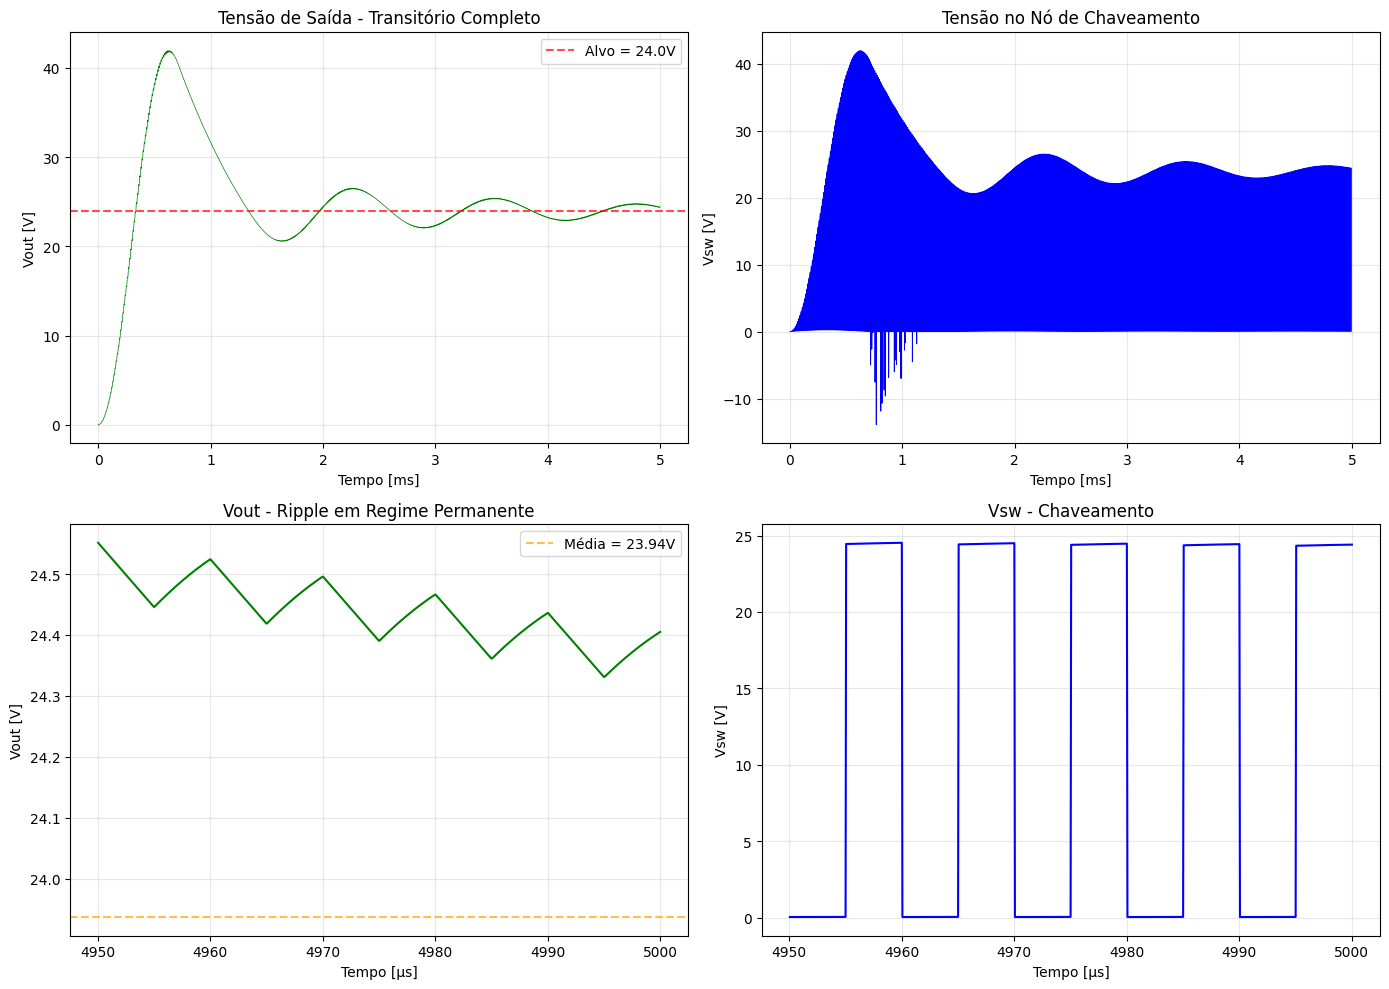

In [46]:
# ============================================================
# GRÁFICOS - MALHA ABERTA
# ============================================================

if success and len(times) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Vout completo
    ax = axes[0, 0]
    ax.plot(times_arr*1e3, v_out, 'g-', linewidth=0.5)
    ax.axhline(Vout, color='r', linestyle='--', alpha=0.7, label=f'Alvo = {Vout}V')
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Vout [V]')
    ax.set_title('Tensão de Saída - Transitório Completo')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Vsw
    ax = axes[0, 1]
    ax.plot(times_arr*1e3, v_sw, 'b-', linewidth=0.5)
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Vsw [V]')
    ax.set_title('Tensão no Nó de Chaveamento')
    ax.grid(True, alpha=0.3)
    
    # Vout zoom regime permanente (últimos 10 períodos)
    n_zoom = int(10 * Tsw / dt)
    ax = axes[1, 0]
    ax.plot(times_arr[-n_zoom:]*1e6, v_out[-n_zoom:], 'g-', linewidth=1.5)
    ax.axhline(v_out_avg, color='orange', linestyle='--', alpha=0.7, label=f'Média = {v_out_avg:.2f}V')
    ax.set_xlabel('Tempo [µs]')
    ax.set_ylabel('Vout [V]')
    ax.set_title('Vout - Ripple em Regime Permanente')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Vsw zoom
    ax = axes[1, 1]
    ax.plot(times_arr[-n_zoom:]*1e6, v_sw[-n_zoom:], 'b-', linewidth=1.5)
    ax.set_xlabel('Tempo [µs]')
    ax.set_ylabel('Vsw [V]')
    ax.set_title('Vsw - Chaveamento')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Simulação em Malha Fechada

Agora vamos adicionar o controlador PI projetado para regular a tensão de saída.

In [47]:
# ============================================================
# FUNÇÃO DE SIMULAÇÃO COM PI (BACKEND VIRTUAL)
# ============================================================

def simulate_boost_closed_loop(
    Vin,
    L,
    C,
    R_load,
    fsw,
    V_ref,
    Kp,
    Ki,
    n_periods=1000,
    dt_factor=100,
    D_init=None,
    D_min=0.10,
    D_max=0.80,
    duty_slew=0.005,
    control_periods=4,
    feedback_alpha=0.99,
    duty_window=0.06,
    softstart_periods=200,
):
    """
    Simula Boost converter em malha fechada com PI no backend mixed-domain.

    Estratégia usada para robustez e estabilidade:
    - circuito único ao longo da simulação (preserva estado interno);
    - feedforward de duty (modelo ideal) + correção PI;
    - feedback filtrado de Vout;
    - atualização do controlador em taxa mais baixa que o PWM.
    """
    Tsw = 1 / fsw
    dt_base = Tsw / dt_factor
    control_periods = max(1, int(control_periods))

    duty_ff_nom = float(np.clip(1.0 - Vin / max(V_ref, 1e-3), D_min, D_max))
    if D_init is None:
        D_init = D_min

    # PI no backend (saída = correção de duty)
    ctrl = ps.Circuit()
    n_ref_ctrl = ctrl.add_node("v_ref")
    n_fb_ctrl = ctrl.add_node("v_fb")
    n_aux_ctrl = ctrl.add_node("u_ctrl")
    ctrl.add_virtual_component(
        "pi_controller",
        "PI_LOOP",
        [n_ref_ctrl, n_fb_ctrl, n_aux_ctrl],
        {
            "kp": float(Kp),
            "ki": float(Ki),
            "output_min": -float(duty_window),
            "output_max": float(duty_window),
            "anti_windup": 1.0,
        },
        {},
    )
    x_ctrl = np.zeros(ctrl.system_size())

    # Histórico
    time_hist = []
    vout_hist = []
    vout_filt_hist = []
    duty_hist = []
    error_hist = []
    vref_hist = []

    current_duty = float(np.clip(D_init, D_min, D_max))
    t = 0.0
    vout_filtered = None

    # Mantém um único circuito para robustez numérica
    ckt, nodes = create_boost_circuit(Vin, L, C, R_load, fsw, current_duty)
    x = np.zeros(ckt.system_size())

    success = True
    fail_msg = "OK"

    print(f"Simulando {n_periods} períodos com PI backend (Kp={Kp:.4f}, Ki={Ki:.1f})...")

    for period in range(n_periods):
        vref_eff = V_ref * min(1.0, (period + 1) / max(1, softstart_periods))
        duty_ff = float(np.clip(1.0 - Vin / max(vref_eff, 1e-3), D_min, D_max))

        # Tentativa base
        newton_opts = ps.NewtonOptions()
        newton_opts.max_iterations = 120
        times, states, ok, msg = run_transient_compat(
            ckt,
            t,
            t + Tsw,
            dt_base,
            x,
            newton_opts,
        )

        # Resgate extra em caso de falha
        if not ok:
            rescue_opts = ps.NewtonOptions()
            rescue_opts.max_iterations = 320
            times, states, ok, msg = run_transient_compat(
                ckt,
                t,
                t + Tsw,
                dt_base * 0.5,
                x,
                rescue_opts,
                robust=False,
                auto_regularize=True,
            )

        if not ok:
            print(f"Falha no período {period}: {msg}")
            success = False
            fail_msg = msg
            break

        states_arr = np.array(states)
        x = states_arr[-1].copy()
        t += Tsw

        n_out = nodes['n_out']
        V_out_period = float(np.mean(states_arr[:, n_out]))

        if vout_filtered is None:
            vout_filtered = V_out_period
        else:
            vout_filtered = feedback_alpha * vout_filtered + (1.0 - feedback_alpha) * V_out_period

        # Atualização de controle desacoplada do PWM
        if period % control_periods == 0:
            x_ctrl[n_ref_ctrl] = vref_eff
            x_ctrl[n_fb_ctrl] = vout_filtered
            ctrl_step = ctrl.execute_mixed_domain_step(x_ctrl, t)
            duty_corr = float(ctrl_step.channel_values["PI_LOOP"])
            duty_target = float(np.clip(duty_ff + duty_corr, D_min, D_max))
            duty_delta = np.clip(duty_target - current_duty, -duty_slew, duty_slew)
            current_duty = float(np.clip(current_duty + duty_delta, D_min, D_max))
            ckt.set_pwm_duty("Vpwm", current_duty)

        # Registro
        error = vref_eff - vout_filtered
        time_hist.append(t * 1e3)  # ms
        vout_hist.append(V_out_period)
        vout_filt_hist.append(vout_filtered)
        duty_hist.append(current_duty)
        error_hist.append(error)
        vref_hist.append(vref_eff)

        if period < 5 or period % 100 == 0:
            print(
                f"  Período {period}: Vout={V_out_period:.2f}V, "
                f"Vout_filt={vout_filtered:.2f}V, D={current_duty:.3f}"
            )

    return {
        'time': np.array(time_hist),
        'vout': np.array(vout_hist),
        'vout_filtered': np.array(vout_filt_hist),
        'duty': np.array(duty_hist),
        'error': np.array(error_hist),
        'vref_eff': np.array(vref_hist),
        'success': success and len(time_hist) == n_periods,
        'message': fail_msg,
    }


In [48]:
# ============================================================
# SIMULAÇÃO EM MALHA FECHADA
# ============================================================

print("SIMULAÇÃO EM MALHA FECHADA")
print("="*50)

V_ref = Vout  # Referência de tensão

print(f"\nControlador PI:")
print(f"  Kp = {pi_params['Kp']:.4f}")
print(f"  Ki = {pi_params['Ki']:.1f}")
print(f"  V_ref = {V_ref}V")

# Simular
start_time = time.time()
results_cl = simulate_boost_closed_loop(
    Vin_nom, L, C, R_load, fsw, V_ref,
    pi_params['Kp'], pi_params['Ki'],
    n_periods=5000,
    dt_factor=100,
    D_init=None,
    D_min=0.10,
    D_max=0.80,
    duty_slew=0.005,
    control_periods=4,
    feedback_alpha=0.99,
    duty_window=0.06,
    softstart_periods=200,
)
elapsed = time.time() - start_time

print(f"\nTempo de execução: {elapsed:.1f}s")


SIMULAÇÃO EM MALHA FECHADA

Controlador PI:
  Kp = 0.0040
  Ki = 10.0
  V_ref = 24.0V
Simulando 5000 períodos com PI backend (Kp=0.0040, Ki=10.0)...
  Período 0: Vout=0.02V, Vout_filt=0.02V, D=0.100
  Período 1: Vout=0.12V, Vout_filt=0.02V, D=0.100
  Período 2: Vout=0.34V, Vout_filt=0.02V, D=0.100
  Período 3: Vout=0.65V, Vout_filt=0.03V, D=0.100
  Período 4: Vout=1.06V, Vout_filt=0.04V, D=0.102
  Período 100: Vout=14.32V, Vout_filt=11.06V, D=0.105
  Período 200: Vout=14.36V, Vout_filt=13.13V, D=0.225
  Período 300: Vout=17.56V, Vout_filt=15.38V, D=0.350
  Período 400: Vout=21.70V, Vout_filt=18.47V, D=0.475
  Período 500: Vout=27.80V, Vout_filt=22.93V, D=0.559
  Período 600: Vout=25.49V, Vout_filt=25.23V, D=0.544
  Período 700: Vout=25.18V, Vout_filt=25.64V, D=0.527
  Período 800: Vout=25.16V, Vout_filt=25.20V, D=0.516
  Período 900: Vout=24.79V, Vout_filt=24.70V, D=0.509
  Período 1000: Vout=24.11V, Vout_filt=24.21V, D=0.506
  Período 1100: Vout=23.80V, Vout_filt=24.13V, D=0.504
  Per

In [49]:
# ============================================================
# RESULTADOS - MALHA FECHADA
# ============================================================

if results_cl['success']:
    # Regime permanente (últimos 20%)
    idx_st = int(0.8 * len(results_cl['vout']))

    vout_raw_steady = results_cl['vout'][idx_st:]
    vout_filt_steady = results_cl['vout_filtered'][idx_st:]
    duty_steady_cl = results_cl['duty'][idx_st:]

    vout_avg_cl = np.mean(vout_raw_steady)
    vout_filt_avg_cl = np.mean(vout_filt_steady)
    duty_avg_cl = np.mean(duty_steady_cl)
    erro_cl = (vout_avg_cl - V_ref) / V_ref * 100

    print("\nRESULTADOS - MALHA FECHADA")
    print("="*50)
    print(f"\nRegime Permanente:")
    print(f"  Vout médio (bruto): {vout_avg_cl:.4f}V")
    print(f"  Vout médio (filtrado): {vout_filt_avg_cl:.4f}V")
    print(f"  V_ref: {V_ref}V")
    print(f"  Erro: {erro_cl:+.4f}%")
    print(f"  Duty: {duty_avg_cl:.2%}")
else:
    print("Simulação em malha fechada falhou.")



RESULTADOS - MALHA FECHADA

Regime Permanente:
  Vout médio (bruto): 24.0375V
  Vout médio (filtrado): 23.9937V
  V_ref: 24.0V
  Erro: +0.1563%
  Duty: 49.94%


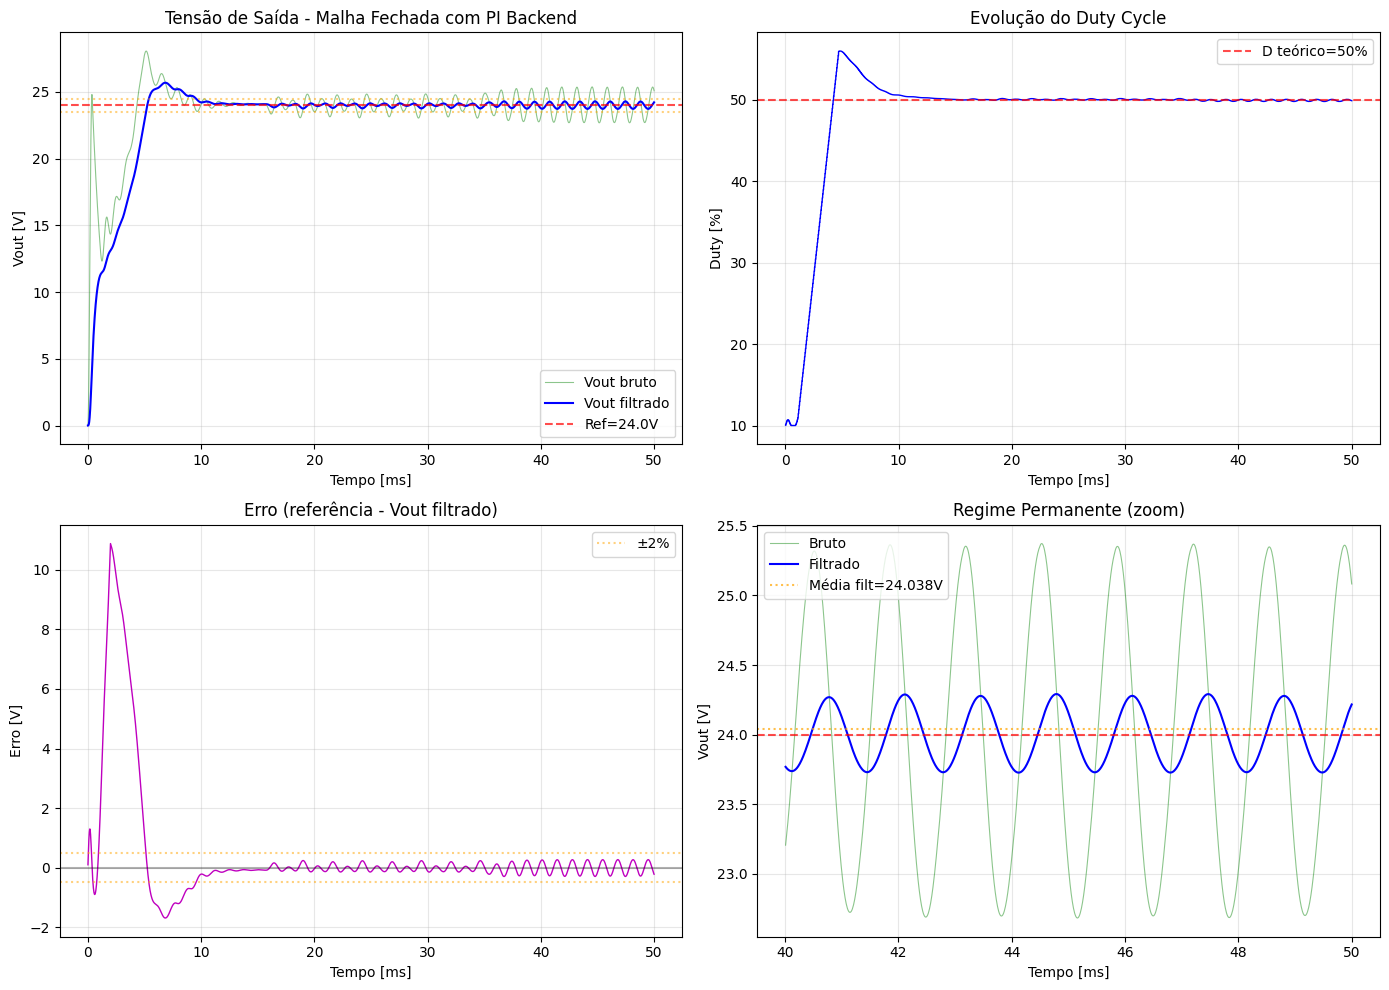

In [50]:
# ============================================================
# GRÁFICOS - MALHA FECHADA
# ============================================================

if results_cl['success']:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    time_cl = results_cl['time']
    vout_cl = results_cl['vout']
    vout_filt_cl = results_cl['vout_filtered']
    duty_cl = results_cl['duty']
    error_cl = results_cl['error']

    # Vout
    ax = axes[0, 0]
    ax.plot(time_cl, vout_cl, 'g-', linewidth=0.8, alpha=0.45, label='Vout bruto')
    ax.plot(time_cl, vout_filt_cl, 'b-', linewidth=1.5, label='Vout filtrado')
    ax.axhline(V_ref, color='r', linestyle='--', alpha=0.7, label=f'Ref={V_ref}V')
    ax.axhline(V_ref*0.98, color='orange', linestyle=':', alpha=0.5)
    ax.axhline(V_ref*1.02, color='orange', linestyle=':', alpha=0.5)
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Vout [V]')
    ax.set_title('Tensão de Saída - Malha Fechada com PI Backend')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Duty
    ax = axes[0, 1]
    ax.plot(time_cl, np.array(duty_cl)*100, 'b-', linewidth=1)
    ax.axhline(D_nom*100, color='r', linestyle='--', alpha=0.7, label=f'D teórico={D_nom:.0%}')
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Duty [%]')
    ax.set_title('Evolução do Duty Cycle')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Erro
    ax = axes[1, 0]
    ax.plot(time_cl, error_cl, 'm-', linewidth=1)
    ax.axhline(0, color='k', linestyle='-', alpha=0.3)
    ax.axhline(V_ref*0.02, color='orange', linestyle=':', alpha=0.5, label='±2%')
    ax.axhline(-V_ref*0.02, color='orange', linestyle=':', alpha=0.5)
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Erro [V]')
    ax.set_title('Erro (referência - Vout filtrado)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Zoom Vout
    ax = axes[1, 1]
    ax.plot(time_cl[idx_st:], vout_cl[idx_st:], 'g-', linewidth=0.8, alpha=0.45, label='Bruto')
    ax.plot(time_cl[idx_st:], vout_filt_cl[idx_st:], 'b-', linewidth=1.5, label='Filtrado')
    ax.axhline(V_ref, color='r', linestyle='--', alpha=0.7)
    ax.axhline(vout_avg_cl, color='orange', linestyle=':', alpha=0.7, label=f'Média filt={vout_avg_cl:.3f}V')
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Vout [V]')
    ax.set_title('Regime Permanente (zoom)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## 8. Resumo do Projeto

In [51]:
# ============================================================
# RESUMO FINAL DO PROJETO
# ============================================================

print("="*70)
print("RESUMO DO PROJETO DO BOOST CONVERTER")
print("="*70)

print("\n1. ESPECIFICAÇÕES:")
print(f"   Vin: {Vin_min}V - {Vin_max}V (nominal {Vin_nom}V)")
print(f"   Vout: {Vout}V")
print(f"   Pout: {Pout}W")
print(f"   fsw: {fsw/1e3:.0f}kHz")

print("\n2. COMPONENTES:")
print(f"   Indutor: {L*1e6:.0f}µH")
print(f"   Capacitor: {C*1e6:.0f}µF")
print(f"   Carga: {R_load:.2f}Ω")

print("\n3. CONTROLADOR PI:")
print(f"   Kp = {pi_params['Kp']:.4f}")
print(f"   Ki = {pi_params['Ki']:.1f}")
print(f"   fc ≈ {pi_params['fc']:.0f}Hz")

print("\n4. DESEMPENHO (Simulação):")
try:
    if success and len(times) > 0:
        print(f"   Malha Aberta:")
        print(f"     Vout médio: {v_out_avg:.2f}V")
        print(f"     Erro: {(v_out_avg-Vout)/Vout*100:+.1f}%")
except:
    print("   Malha Aberta: (executar células anteriores)")

try:
    if results_cl['success']:
        print(f"   Malha Fechada:")
        print(f"     Vout médio: {vout_avg_cl:.2f}V")
        print(f"     Erro: {erro_cl:+.2f}%")
except:
    print("   Malha Fechada: (executar células anteriores)")

print("\n" + "="*70)
print("PROJETO COMPLETO DO BOOST CONVERTER!")
print("="*70)

RESUMO DO PROJETO DO BOOST CONVERTER

1. ESPECIFICAÇÕES:
   Vin: 10.0V - 14.0V (nominal 12.0V)
   Vout: 24.0V
   Pout: 50.0W
   fsw: 100kHz

2. COMPONENTES:
   Indutor: 100µH
   Capacitor: 100µF
   Carga: 11.52Ω

3. CONTROLADOR PI:
   Kp = 0.0040
   Ki = 10.0
   fc ≈ 265Hz

4. DESEMPENHO (Simulação):
   Malha Aberta:
     Vout médio: 23.94V
     Erro: -0.3%
   Malha Fechada:
     Vout médio: 24.04V
     Erro: +0.16%

PROJETO COMPLETO DO BOOST CONVERTER!
